<a href="https://colab.research.google.com/github/WeAreDobby/CV_project/blob/main/AutoEncoder/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Drive 연동
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from IPython import display

import os
from tqdm import tqdm
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [2]:
# Load Pocketmon Dataset
def find_path(path):
    file_list = os.listdir(path)
    return file_list

def png_to_np(path, file_list, read_type='rgb'):
    pix = []
    for idx in tqdm(range(len(file_list))):
      file_name = file_list[idx]
      if read_type == "rgb":
        image = PIL.Image.open(path + '/' + file_name) # (256, 256, 3)
      elif read_type == "gray":
        image = PIL.Image.open(path + '/' + file_name).convert("L") # (256, 256, 1)
      np_image = np.array(image).astype(np.float32) / 255.0
      pix.append(np_image)
    return pix

In [ ]:
# 포켓몬 데이터셋 받는부분
path = 'drive/MyDrive/dataset/jpg/jpg_dataset_32'

file_list = find_path(path)

images = png_to_np(path, file_list, 'gray')

train_dataset = np.array(images[:768])
test_dataset = np.array(images[768:])

train_dataset = train_dataset.reshape(768, 1024)
test_dataset = test_dataset.reshape(130, 1024)

# GrayScale일때 1channel을 만들어주기위해 활용
#train_dataset = train_dataset[..., tf.newaxis]
#test_dataset = test_dataset[..., tf.newaxis]

len(train_dataset), len(test_dataset)

train_size = 768
batch_size = 32
test_size = 130

#train_dataset = (tf.data.Dataset.from_tensor_slices(train_dataset)
#                 .shuffle(train_size).batch(batch_size))
#test_dataset = (tf.data.Dataset.from_tensor_slices(test_dataset)
#                .shuffle(test_size).batch(batch_size))


100%|██████████| 898/898 [00:00<00:00, 949.00it/s]


In [3]:
# MNIST 데이터셋 받는부분
mnist = tf.keras.datasets.mnist

# (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_dataset = x_train[..., tf.newaxis]
test_dataset = x_test[..., tf.newaxis]

train_dataset = train_dataset.reshape(60000, 784)
test_dataset = test_dataset.reshape(10000, 784)

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
'''
input_img = tf.keras.Input(shape=(1024,))

# 포켓몬encoder
encoder1 = tf.keras.layers.Dense(1280, activation='sigmoid')(input_img)
encoder2 = tf.keras.layers.Dense(512, activation='sigmoid')(encoder1)
encoder3 = tf.keras.layers.Dense(256, activation='sigmoid')(encoder2)
encoder4 = tf.keras.layers.Dense(128, activation='sigmoid')(encoder3)
# 포켓몬decoder
decoder1 = tf.keras.layers.Dense(128, activation='sigmoid')(encoder4)
decoder2 = tf.keras.layers.Dense(256, activation='sigmoid')(decoder1)
decoder3 = tf.keras.layers.Dense(512, activation='sigmoid')(decoder2)
decoder4 = tf.keras.layers.Dense(1024)(decoder3)

# this model maps an input to its reconstruction
autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder4)
'''

input_img = tf.keras.Input(shape=(784,))
# MNIST encoder
encoder1 = tf.keras.layers.Dense(1024, activation='sigmoid')(input_img)
encoder2 = tf.keras.layers.Dense(3, activation='sigmoid')(encoder1)
# MNIST decoder
decoder1 = tf.keras.layers.Dense(1024, activation='sigmoid')(encoder2)
decoder2 = tf.keras.layers.Dense(784)(decoder1)

# this model maps an input to its reconstruction
autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)


In [9]:
autoencoder.compile(optimizer='adam', loss='MSE')
autoencoder.fit(train_dataset, train_dataset,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_data=(test_dataset, test_dataset))

Epoch 1/100
938/938 [==============================] - 4s 2ms/step - loss: 4496.5034 - val_loss: 4238.5317
Epoch 2/100
938/938 [==============================] - 2s 2ms/step - loss: 4216.4663 - val_loss: 4199.4229
Epoch 3/100
938/938 [==============================] - 2s 2ms/step - loss: 4127.8096 - val_loss: 4010.8840
Epoch 4/100
938/938 [==============================] - 2s 2ms/step - loss: 3922.3250 - val_loss: 3866.7195
Epoch 5/100
938/938 [==============================] - 2s 2ms/step - loss: 3849.5613 - val_loss: 3824.5144
Epoch 6/100
938/938 [==============================] - 2s 2ms/step - loss: 3805.4138 - val_loss: 3765.9851
Epoch 7/100
938/938 [==============================] - 2s 2ms/step - loss: 3683.8630 - val_loss: 3595.8201
Epoch 8/100
938/938 [==============================] - 2s 2ms/step - loss: 3556.1873 - val_loss: 3512.5972
Epoch 9/100
938/938 [==============================] - 2s 2ms/step - loss: 3485.5098 - val_loss: 3456.7380
Epoch 10/100
938/938 [===============

In [ ]:
# 포켓몬
# create encoder model
encoder = tf.keras.Model(inputs=input_img, outputs=encoder4)
# create decoder model
encoded_input = tf.keras.Input(shape=(128,))
decoder_layer1 = autoencoder.layers[-4]
decoder_layer2 = autoencoder.layers[-3]
decoder_layer3 = autoencoder.layers[-2]
decoder_layer4 = autoencoder.layers[-1]
decoder = tf.keras.Model(inputs=encoded_input, outputs=decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input)))))

In [ ]:
#MNIST
# create encoder model
encoder = tf.keras.Model(inputs=input_img, outputs=encoder2)
# create decoder model
encoded_input = tf.keras.Input(shape=(3,))
decoder_layer1 = autoencoder.layers[-2]
decoder_layer2 = autoencoder.layers[-1]
decoder = tf.keras.Model(inputs=encoded_input, outputs=decoder_layer2(decoder_layer1(encoded_input)))

In [ ]:
# get latent vector for visualization
latent_vector = encoder.predict(test_dataset)
# get decoder output to visualize reconstructed image
reconstructed_imgs = decoder.predict(latent_vector)

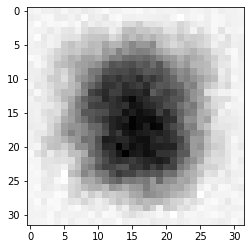

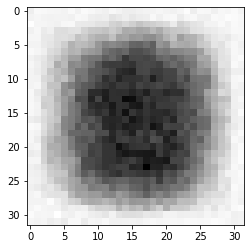

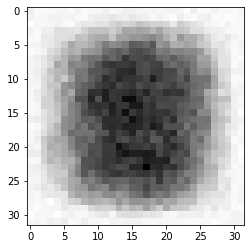

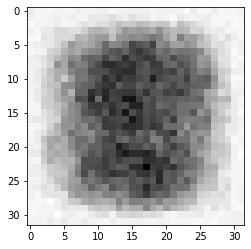

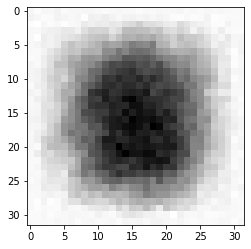

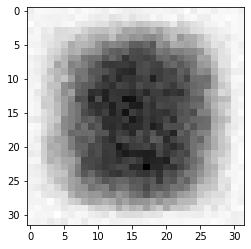

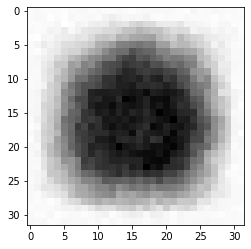

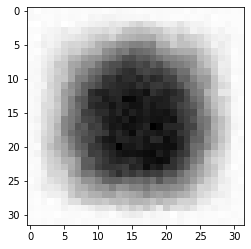

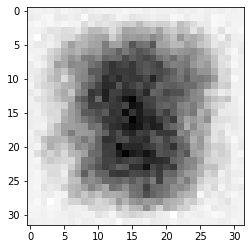

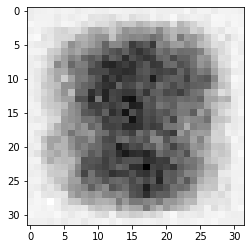

"\nepochs = 10  # how many digits we will display\nfor i in range(epochs):\n    # display original\n    plt.imshow(test_dataset[i].reshape(28, 28), cmap='gray')\n    # display reconstructed image\n    plt.imshow(reconstructed_imgs[i].reshape(28, 28), cmap='gray')\n    plt.show()\n"

In [ ]:
epochs = 10  # how many digits we will display
for i in range(epochs):
    # display original
    plt.imshow(test_dataset[i].reshape(32, 32), cmap='gray')
    # display reconstructed image
    plt.imshow(reconstructed_imgs[i].reshape(32, 32), cmap='gray')
    plt.show()
'''
epochs = 10  # how many digits we will display
for i in range(epochs):
    # display original
    plt.imshow(test_dataset[i].reshape(28, 28), cmap='gray')
    # display reconstructed image
    plt.imshow(reconstructed_imgs[i].reshape(28, 28), cmap='gray')
    plt.show()
'''